In [5]:
import pandas as pd
import numpy as np
import sys
import os
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from simpledbf import Dbf5
import geopandas as gpd

ITERATION = 4
MODEL_FOLDER = r'E:\Met_Council\metc-asim-model\Base_2022_1\highway'

TAZ_SHAPE = r'E:\Met_Council\metc-asim-model\Input_2022\Visualizer\SHP\TAZ2010.shp'

LAND_USE_INPUT = r'E:\Met_Council\metc-asim-model\Input_2022\socioeconomic'

rci_values = {
    1: 'Fway/Expwy',
    2: 'Fway/Expwy',
    3: 'Fway/Expwy',
    4: 'Arterial',
    5: 'Arterial',
    6: 'Arterial',
    7: 'Arterial',
    8: 'Arterial',
    9: 'Arterial',
    10: 'Collector',
    11: 'Collector',
    12: 'Collector',
    15: 'Collector',
    13: 'Ramp',
    14: 'Ramp'
}

rci_2_values = {
    1: 'Fway/Expwy',
    2: 'Fway/Expwy',
    3: 'Div Art',
    4: 'Div Art',
    5: 'Arterial',
    6: 'Div Art',
    7: 'Arterial',
    8: 'Div Art',
    9: 'Arterial',
    10: 'Collector',
    11: 'Collector',
    12: 'Collector',
    15: 'Collector',
    13: 'Ramp',
    14: 'Ramp'
}

land_use = pd.read_csv(os.path.join(LAND_USE_INPUT, 'land_use.csv'))

vmt_county = pd.read_csv(r'E:\Met_Council\metc-asim-model\Input_2022\validation\vmt_by_county.csv').set_index('County')

taz_shape = gpd.read_file(TAZ_SHAPE)
county_shape = taz_shape[['geometry', 'CO_NAME', 'POPTOTAL']].dissolve('CO_NAME', aggfunc='sum').reset_index()

dy_net = gpd.read_file(os.path.join(MODEL_FOLDER, f"HWY_LDNET_{ITERATION}_DY.shp")).rename(columns = {'VOL_TOT_DAI': 'Model'}).set_crs('epsg:3722')
dy_net['linkcode'] = dy_net['A'].astype(str) + "-" + dy_net['B'].astype(str)

link_join = dy_net.sjoin(county_shape).sort_values('POPTOTAL', ascending = False).groupby('linkcode').agg(
    CO_NAME = ('CO_NAME', 'first'),
    Model_mainline = ('Model', 'first'),
    DISTANCE = ('DISTANCE', 'first'), 
    RCI = ('RCI', 'first')).reset_index()



c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\geopandas\geodataframe.py:2177: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3722
Right CRS: EPSG:26915

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [6]:
counts = pd.read_csv("LinkCounts_rev_wWisc.csv")
# REMOVALS - send these to Dennis
remove_locations = ['206112-206111']



counts = counts[counts['MainlineLink'].str.len() > 1]
counts = counts.merge(link_join[['linkcode', 'Model_mainline', 'DISTANCE', 'RCI', 'CO_NAME']], how = 'left', left_on = 'MainlineLink', right_on = 'linkcode')
counts = counts.merge(link_join[['linkcode', 'Model_mainline']].rename(columns = {'Model_mainline': 'Model_HOT'}), how = 'left', left_on = 'HOTLink', right_on = 'linkcode')


# counts = counts.merge(dy_net[['linkcode', 'Model']].rename(columns = {'Model': 'Model_HOT'}), how = 'left', left_on = 'HOTLink', right_on = 'linkcode')
counts['TOT_COUNT'] = counts['HOT_Daily'].fillna(0) + counts['Mainline_Daily'].fillna(0)
counts['TOT_MODEL'] = counts['Model_mainline'].fillna(0) + counts['Model_HOT'].fillna(0)
counts['COUNT_VMT'] = counts['TOT_COUNT'] * counts['DISTANCE']
counts['MODEL_VMT'] = counts['TOT_MODEL'] * counts['DISTANCE']
counts['FTYPE'] = counts['RCI'].map(rci_values)
counts['FTYPE2'] = counts['RCI'].map(rci_2_values)
dy_net['Model_VMT'] = dy_net['Model'] * dy_net['DISTANCE']



In [67]:
counts

,NODE_LON,NODE_LAT,NODE_NAME,HOTLink,MainlineLink,Mananged Volumes,HOT_Daily,Mainline_Daily,HOT_AM,Mainline_AM,...,CO_NAME,linkcode_y,Model_HOT,TOT_COUNT,TOT_MODEL,COUNT_VMT,MODEL_VMT,FTYPE,FTYPE2,VG
9,-93.18502,45.01032,rnd_86779,NaN,121734-121448,0.0,0.0,35909.75000,0.0,9762.3750,...,Ramsey,NaN,NaN,35909.75000,44243.91797,7931.027385,9771.711723,Fway/Expwy,Fway/Expwy,1.232086
27,-93.18275,45.08490,rnd_1517,NaN,126204-126205,0.0,0.0,34590.35714,0.0,7420.8750,...,Ramsey,NaN,NaN,34590.35714,32057.29102,5454.899321,5055.434794,Fway/Expwy,Div Art,0.926770
29,-93.16825,44.82907,rnd_87629,NaN,79453-198522,0.0,0.0,36349.18750,0.0,11343.8125,...,Dakota,NaN,NaN,36349.18750,34072.66016,23843.976524,22350.642885,Fway/Expwy,Fway/Expwy,0.937371
30,-93.16790,45.01003,rnd_86621,NaN,121788-121791,0.0,0.0,37857.93750,0.0,7321.0000,...,Ramsey,NaN,NaN,37857.93750,47449.81641,6441.906645,8074.060760,Fway/Expwy,Fway/Expwy,1.253365
36,-93.16964,45.07344,rnd_1785,NaN,218622-299005,0.0,0.0,30071.27273,0.0,6486.8125,...,Ramsey,NaN,NaN,30071.27273,28524.70703,44370.162913,42088.205223,Fway/Expwy,Fway/Expwy,0.948570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4209,NaN,NaN,w 551025,NaN,192660-194867,NaN,NaN,3550.00000,NaN,NaN,...,St. Croix,NaN,NaN,3550.00000,4880.74268,2114.557500,2907.214377,Arterial,Arterial,1.374857
4210,NaN,NaN,w 551214,NaN,193155-195484,NaN,NaN,2650.00000,NaN,NaN,...,St. Croix,NaN,NaN,2650.00000,4854.52734,2585.048500,4735.542875,Arterial,Arterial,1.831897
4211,NaN,NaN,w 554006,NaN,331090-331091,NaN,NaN,3400.00000,NaN,NaN,...,St. Croix,NaN,NaN,3400.00000,1819.11731,169.558000,90.719380,Collector,Collector,0.535035
4212,NaN,NaN,w 554033,NaN,193138-193137,NaN,NaN,430.00000,NaN,NaN,...,St. Croix,NaN,NaN,430.00000,881.58000,104.098700,213.421702,Arterial,Arterial,2.050186


In [8]:
# From https://www.fsutmsonline.net/images/uploads/reports/FR2_FDOT_Model_CalVal_Standards_Final_Report_10.2.08.pdf 2-19
fldot_ftype_stds = pd.DataFrame({'FTYPE2': ['Fway/Expwy','Div Art','Arterial','Collector','Ramp'], 
    'FDOT_Acceptable': [0.07, 0.15, 0.15, 0.25, 0.25], 'FDOT_Preferable': [0.06, 0.1, 0.1, 0.2, 0.2]}).set_index('FTYPE2')


In [9]:

counts = counts[counts['TOT_COUNT'].fillna(0) > 0]

In [10]:
counts[(counts['TOT_COUNT'].fillna(0) > 0) & (counts['TOT_MODEL'].fillna(0) == 0)][['MainlineLink', 'TOT_COUNT', 'TOT_MODEL']].to_excel('no_assign.xlsx')

In [11]:
pd.DataFrame(counts[counts['TOT_COUNT'] > 0][['COUNT_VMT', 'MODEL_VMT']].sum()).style.format('{:,.0f}')

,0
COUNT_VMT,"11,548,391"
MODEL_VMT,"10,856,782"


In [12]:
counts.groupby('FTYPE').agg(Count_VMT = ('COUNT_VMT', 'sum'), Model_VMT = ('MODEL_VMT', 'sum')).style.format('{:,.0f}')

,Count_VMT,Model_VMT
FTYPE,,
Arterial,"723,967","810,366"
Collector,"207,749","200,807"
Fway/Expwy,"10,616,676","9,845,609"


In [13]:
vmt_diff = counts[counts['TOT_COUNT'] > 0]['MODEL_VMT'].sum() - counts[counts['TOT_COUNT'] > 0]['COUNT_VMT'].sum()
pct_diff = vmt_diff / counts[counts['TOT_COUNT'] > 0]['COUNT_VMT'].sum()
print(f"Difference: {vmt_diff:,.0f} ({pct_diff:.2%})")

Difference: -691,609 (-5.99%)


## Count Difference

In [14]:
cnt_diff = (counts[counts['TOT_COUNT'] > 0]['TOT_MODEL'] - counts[counts['TOT_COUNT'] > 0]['TOT_COUNT'])

cnt_pct_diff = cnt_diff / counts[counts['TOT_COUNT'] > 0]['TOT_COUNT']

print(f"Total count difference: {cnt_diff.sum():,.0f} ({cnt_diff.sum() / counts[counts['TOT_COUNT'] > 0]['TOT_COUNT'].sum():.2%})") 
print(f"Mean abs count difference: {cnt_diff.abs().mean():,.0f}")


Total count difference: -684,765 (-3.23%)
Mean abs count difference: 1,627


In [15]:
counts['VG'] = counts['TOT_MODEL'] / counts['TOT_COUNT']
counts.groupby('FTYPE2').agg(avg_vg = ('VG', 'mean')).join(fldot_ftype_stds)

,avg_vg,FDOT_Acceptable,FDOT_Preferable
FTYPE2,,,
Arterial,1.605214,0.15,0.10
Collector,1.343451,0.25,0.20
Div Art,1.079754,0.15,0.10
Fway/Expwy,1.125352,0.07,0.06


<Axes: >

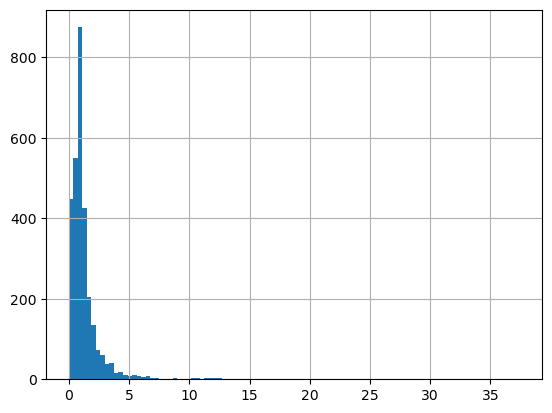

In [16]:
counts[counts['TOT_COUNT'] > 200]['VG'].hist(bins = 100)

In [17]:
x = counts[counts['TOT_COUNT'] > 0]
print(f"RMSE: {np.sqrt(((x.TOT_MODEL - x.TOT_COUNT)**2).sum() / x.shape[0]) / (x.TOT_COUNT.sum() / (x.TOT_COUNT.count()-1)):.2%}")

RMSE: 50.95%


## Count Scatter

Slope = 1.0196728902360386, intercept = 88.25027112452365


c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


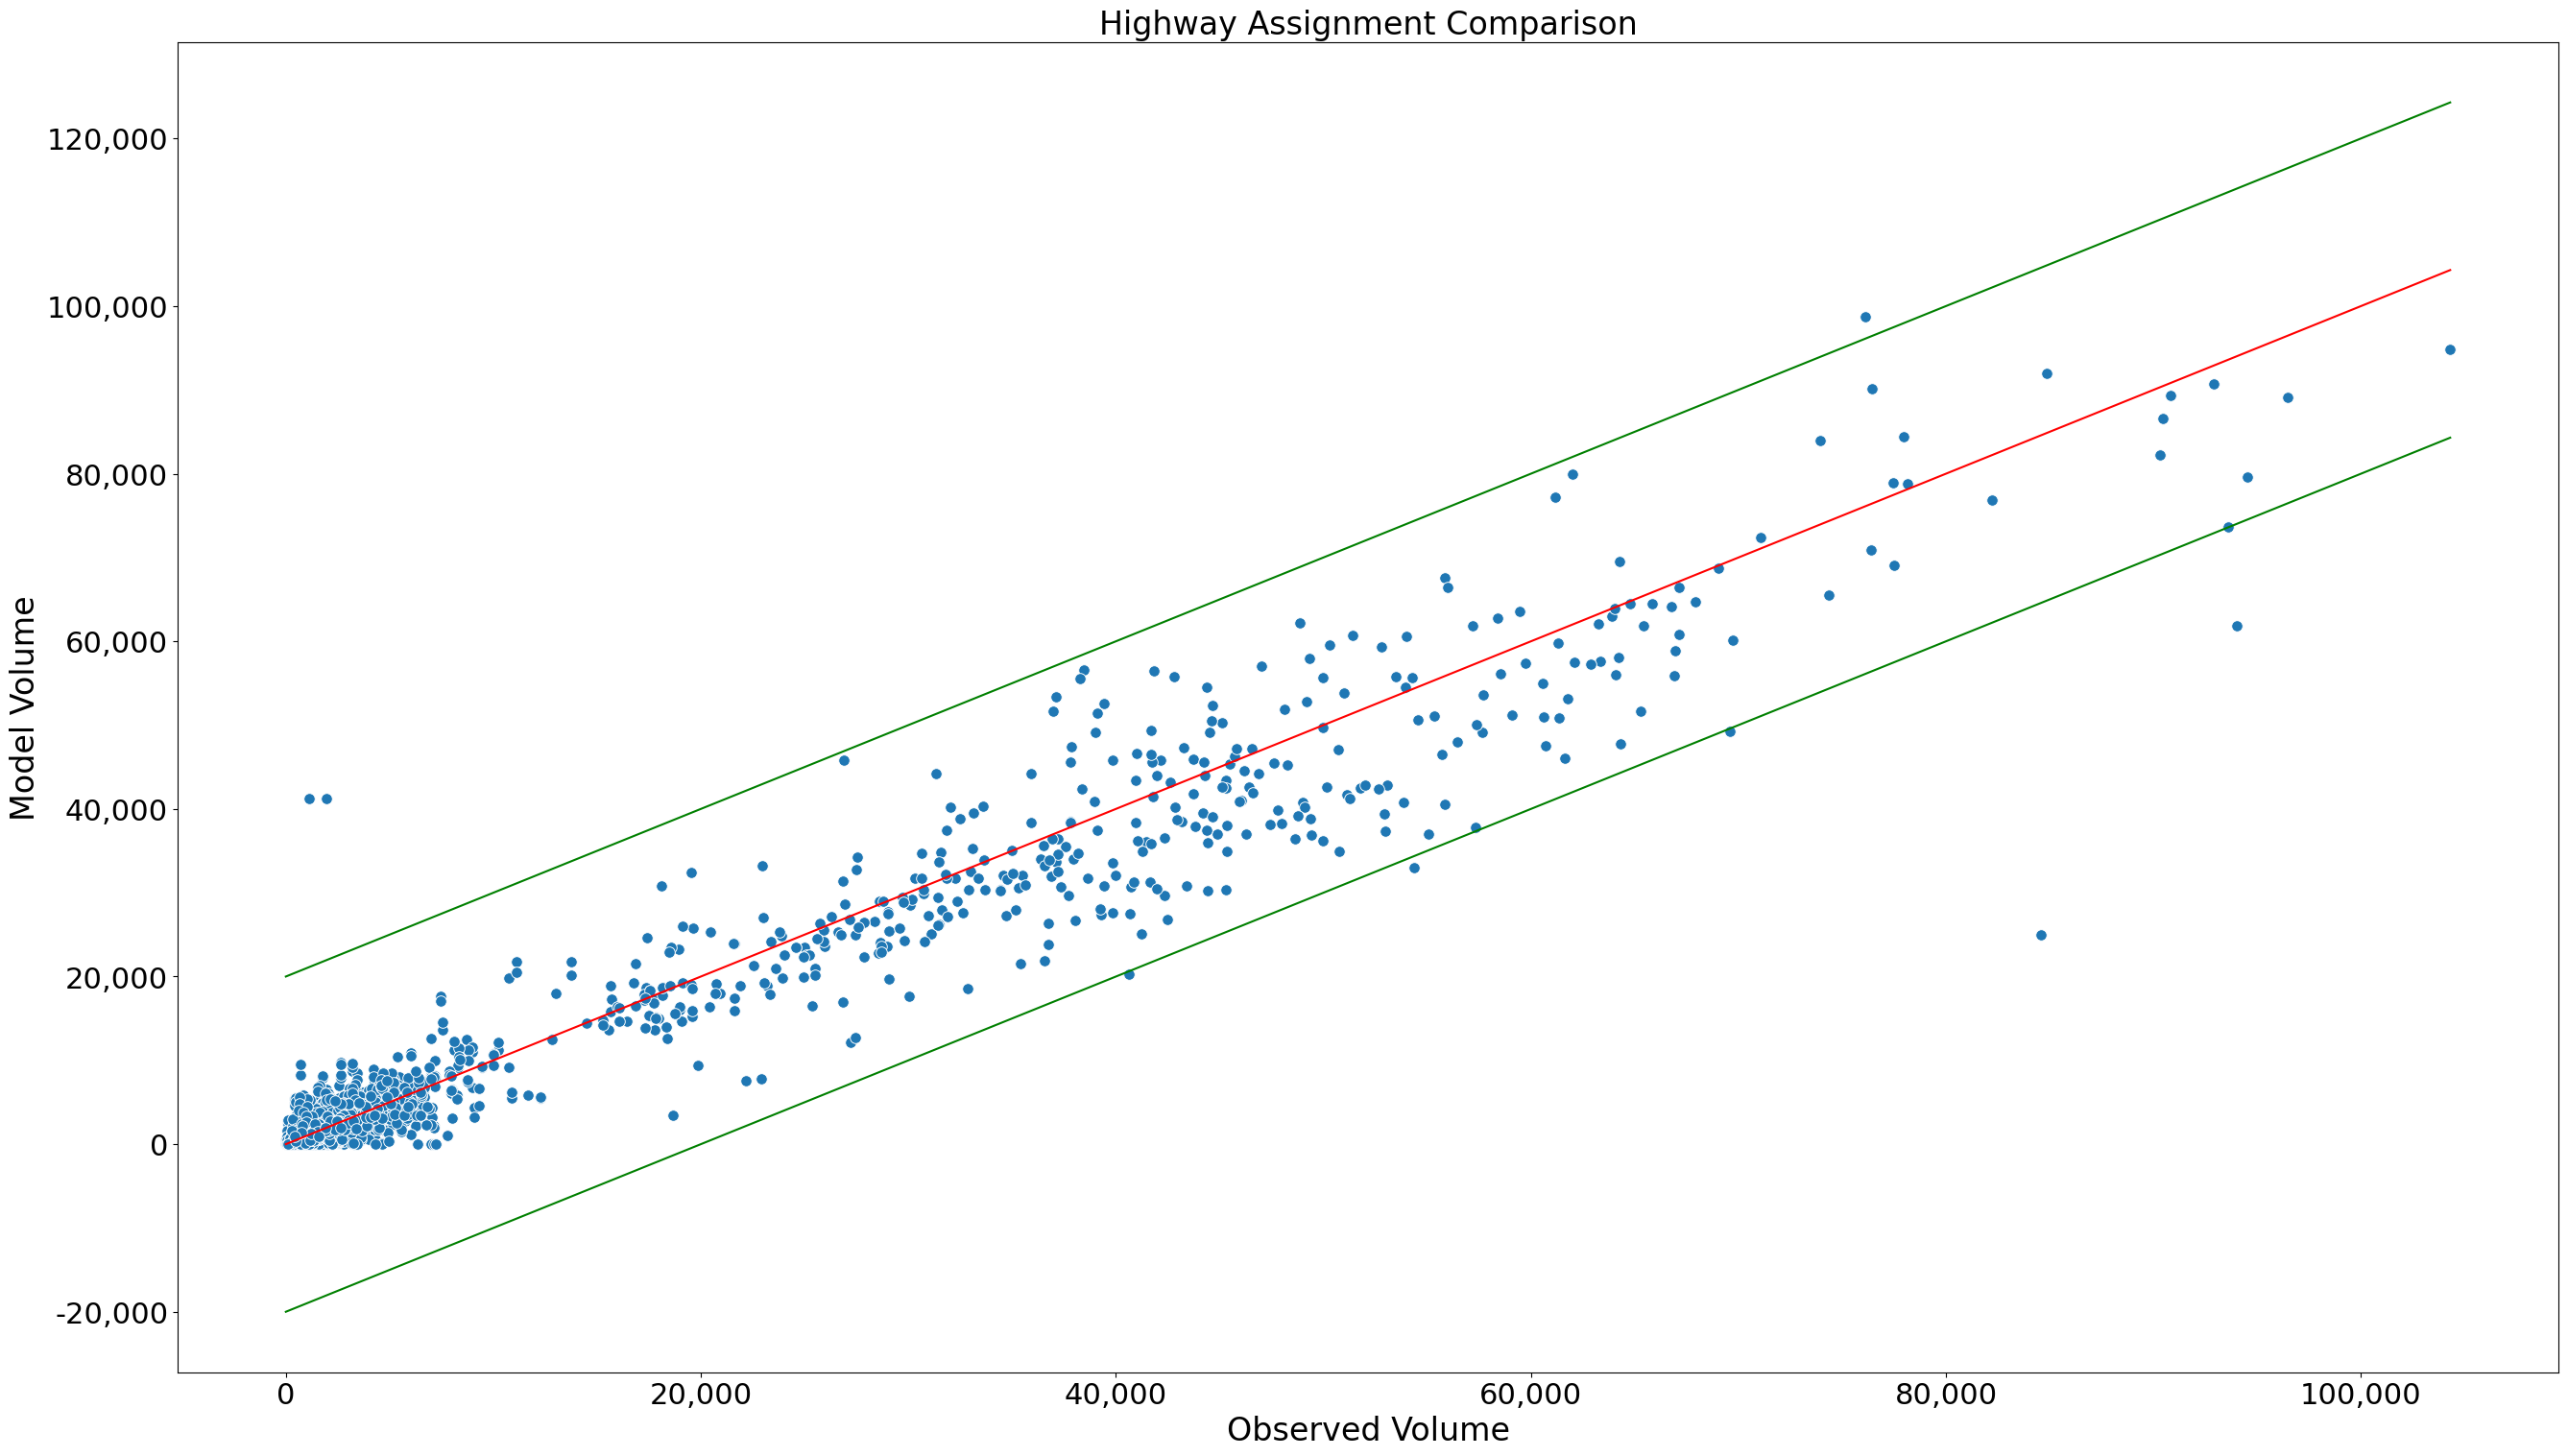

In [18]:
# counts[counts['TOT_COUNT'] > 0].plot(x = 'TOT_COUNT', y = 'TOT_MODEL', kind = 'scatter')
m,b = np.polyfit(counts[(counts['TOT_COUNT'].fillna(0) > 0)]['TOT_MODEL'], counts[counts['TOT_COUNT'].fillna(0) > 0]['TOT_COUNT'], 1)
poly1d_fn = np.poly1d(np.polyfit(counts[counts['TOT_COUNT'].fillna(0) > 0]['TOT_MODEL'], counts[counts['TOT_COUNT'].fillna(0) > 0]['TOT_COUNT'], 1)) 
print(f"Slope = {m}, intercept = {b}")

fun2 = np.poly1d([0, 1, 20000])
fun3 = np.poly1d([0, 1, -20000])

ftype_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'black', 5: 'black', 6: 'black'}

plot_data = counts[counts['TOT_COUNT'] > 0]
x_pred = np.linspace(0, np.max(np.max(plot_data[['TOT_MODEL', 'TOT_COUNT']])), 100)
yy_pred = np.linspace
fig, ax = plt.subplots(figsize=(32, 18))
plot_idx = 111
plt.subplot(plot_idx)
sns.lineplot(x=x_pred, y=x_pred, ax=ax, color = 'red')
sns.lineplot(x = x_pred, y = fun2(x_pred), color = 'green')
sns.lineplot(x = x_pred, y = fun3(x_pred), color = 'green')
# sns.lineplot(x = x_pred, y = poly1d_fn(x_pred), ax = ax, color = 'black', linestyle='dashed')
sns.scatterplot(data = plot_data, x = 'TOT_COUNT', y = 'TOT_MODEL', s = 70) #, c = plot_data['FTYPE'].map(ftype_colors))
plt.title(f"Highway Assignment Comparison", fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Model Volume', fontsize=24)
plt.xlabel('Observed Volume', fontsize=24)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

In [66]:
counts_output = counts[counts['TOT_COUNT'] > 0]
counts_output['A'] = counts_output['MainlineLink'].apply(lambda x: x.split('-')[0])
counts_output['B'] = counts_output['MainlineLink'].apply(lambda x: x.split('-')[1])

#Count_AM,Count_MD,Count_PM,Count_NT,Count_DY

mlc = counts_output[counts_output['Mainline_Daily'].fillna(0) > 0][['A', 'B', 'Mainline_AM', 'Mainline_MD', 'Mainline_PM', 'Mainline_NT', 'Mainline_Daily']]
mlc.columns = ['A', 'B', 'Count_AM', 'Count_MD', 'Count_PM', 'Count_NT', 'Count_DY']
hotc = counts_output[counts_output['HOT_Daily'].fillna(0) > 0][['A', 'B', 'HOT_AM', 'HOT_MD', 'HOT_PM', 'HOT_NT', 'HOT_Daily']]
hotc.columns = ['A', 'B', 'Count_AM', 'Count_MD', 'Count_PM', 'Count_NT', 'Count_DY']

# pd.concat([mlc, hotc]).to_csv(r'E:\Met_Council\metc-asim-model\source\validation\highway_assignment\counts_for_net.csv', index = False)


## RMSE by VG

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_37428\1234447641.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return((np.sqrt(x)).sum() / x.shape[0])


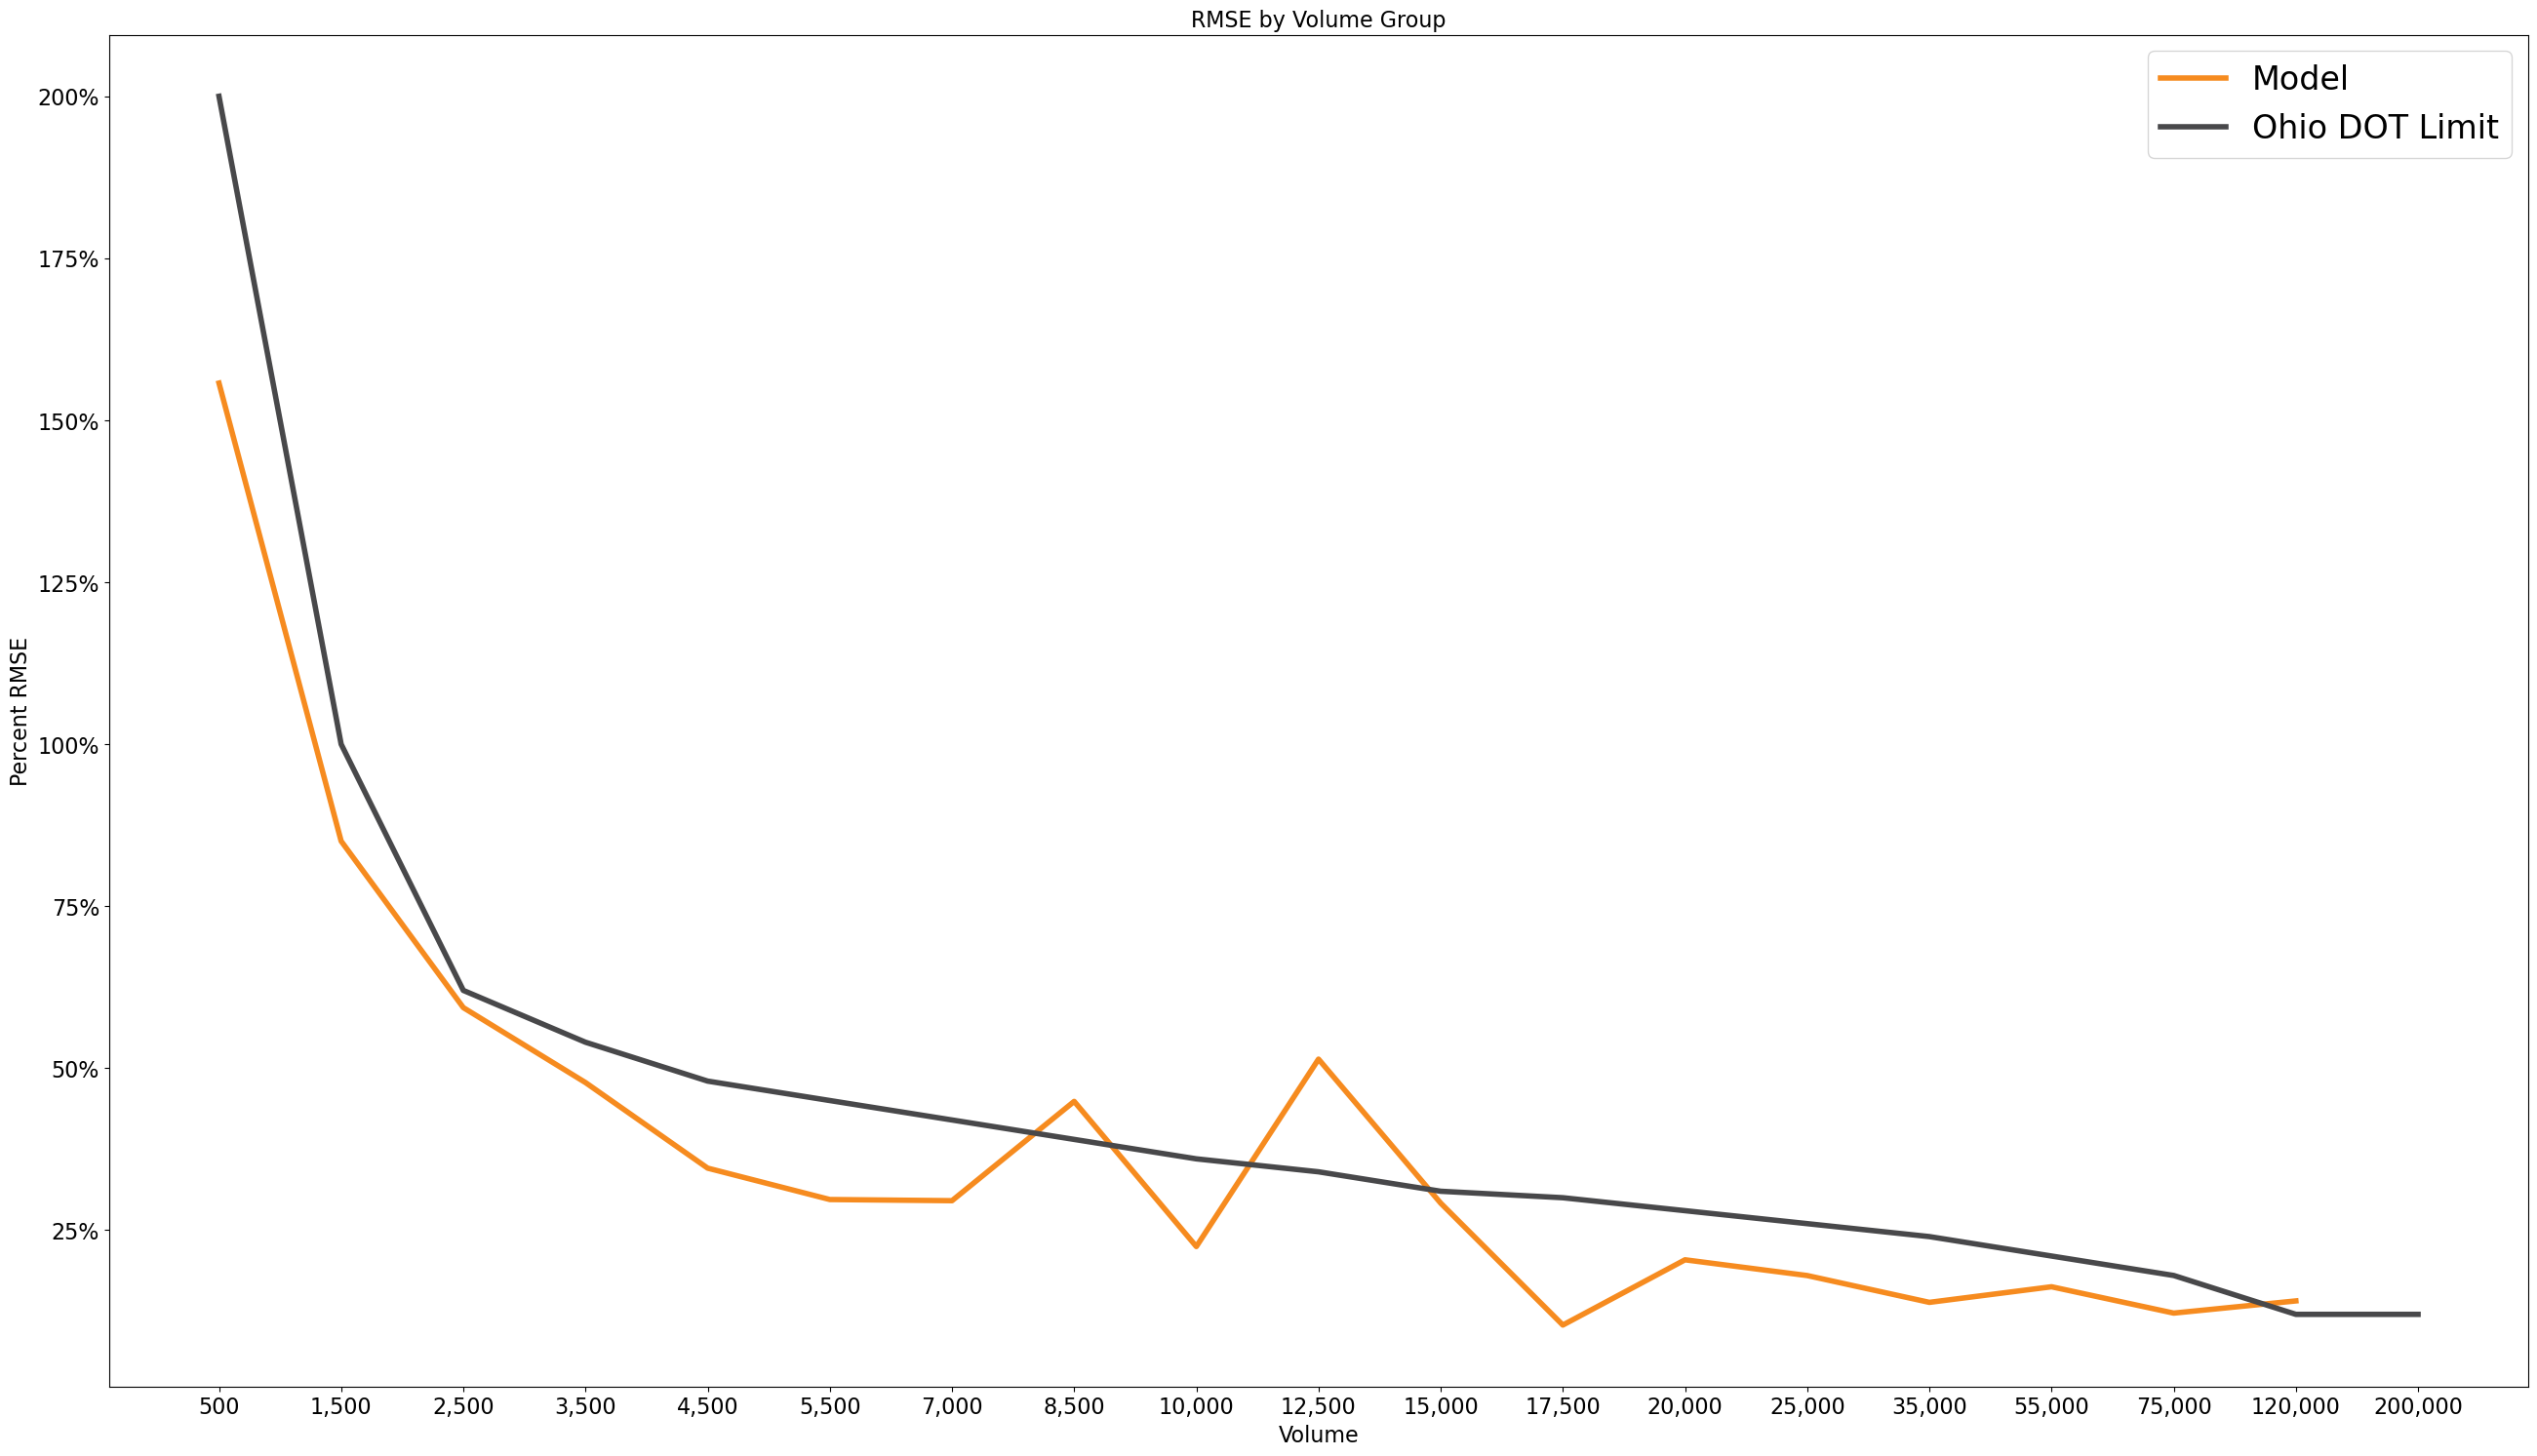

In [19]:
ODOT_VOLUME_GROUPS = [0, 500, 1500, 2500, 3500, 4500, 5500, 7000, 8500, 10000, 12500, 15000, 17500, 20000, 25000, 35000, 55000, 75000, 120000, 200000]
ODOT_RMSE_LIMITS = [200, 100, 62, 54, 48, 45, 42, 39, 36, 34, 31, 30, 28, 26, 24, 21, 18, 12, 12]

x = counts[counts['TOT_COUNT'] > 0]
x['VG'] = pd.cut(x['TOT_COUNT'], ODOT_VOLUME_GROUPS, labels = np.arange(1, len(ODOT_VOLUME_GROUPS)))

def rmse(x):
    return((np.sqrt(x)).sum() / x.shape[0])

rmse_table = x.assign(diff = lambda x: (x['TOT_MODEL'] - x['TOT_COUNT']) ** 2).groupby('VG').agg(n = ('TOT_MODEL', 'count'), rmse = ('diff', rmse), cnt = ('TOT_COUNT', np.mean)).assign(pct_rmse = lambda x: 100.0 * x['rmse'] / x.cnt).assign(VG_LIMIT = ODOT_RMSE_LIMITS)

fig, ax = plt.subplots(figsize=(32, 18))
plot_idx = 111
plt.subplot(plot_idx)
sns.lineplot(x=rmse_table.index, y=rmse_table.pct_rmse / 100.0, ax=ax, color = '#F68B1F', linewidth=4.0, label = 'Model')
sns.lineplot(x=rmse_table.index, y=rmse_table.VG_LIMIT / 100.0, ax=ax, color = '#48484A', linewidth=4.0, label = 'Ohio DOT Limit')
# sns.lineplot(x = x_pred, y = fun2(x_pred), color = 'green')
# sns.lineplot(x = x_pred, y = fun3(x_pred), color = 'green')
# # sns.lineplot(x = x_pred, y = poly1d_fn(x_pred), ax = ax, color = 'black', linestyle='dashed')
# sns.scatterplot(data = plot_data, x = 'TOT_COUNT', y = 'TOT_MODEL') #, c = plot_data['FTYPE'].map(ftype_colors))
plt.legend(fontsize = 24)
plt.title(f"RMSE by Volume Group", fontsize=16)
plt.xticks(fontsize=16, ticks = np.arange(1, len(ODOT_VOLUME_GROUPS)), labels = [f'{x:,.0f}' for x in ODOT_VOLUME_GROUPS[1:]])
plt.yticks(fontsize=16)
plt.ylabel('Percent RMSE', fontsize=16)
plt.xlabel('Volume', fontsize=16)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.0%}'))
# ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))


In [20]:
rmse_table

,n,rmse,cnt,pct_rmse,VG_LIMIT
VG,,,,,
1,673,425.306683,273.101040,155.732356,200
2,890,832.777063,979.261236,85.041359,100
3,498,1145.089172,1929.654618,59.341665,62
4,281,1424.156739,2980.934164,47.775518,54
5,155,1377.130135,3984.200000,34.564784,48
6,126,1474.541409,4961.027778,29.722499,45
7,98,1823.769316,6173.428571,29.542244,42
8,39,3441.888424,7671.076923,44.868386,39
9,18,2077.122730,9245.462963,22.466400,36


## RMSE by Simplified FTYPE

In [21]:
x = counts.copy()
rmse_table = x.assign(diff = lambda x: (x['TOT_MODEL'] - x['TOT_COUNT']) ** 2).groupby('FTYPE').agg(n = ('TOT_MODEL', 'count'), rmse = ('diff', rmse), cnt = ('TOT_COUNT', np.mean)).assign(pct_rmse = lambda x: 100.0 * x['rmse'] / x.cnt)
rmse_table


,n,rmse,cnt,pct_rmse
FTYPE,,,,
Arterial,1533,994.506417,2242.818982,44.341805
Collector,1226,928.225350,1424.950653,65.140877
Fway/Expwy,432,5854.176882,37019.980930,15.813560


## RMSE by County

In [22]:
x = counts.copy()
rmse_table = x.assign(diff = lambda x: (x['TOT_MODEL'] - x['TOT_COUNT']) ** 2).groupby('CO_NAME').agg(n = ('TOT_MODEL', 'count'), rmse = ('diff', rmse), cnt = ('TOT_COUNT', np.mean)).assign(pct_rmse = lambda x: 100.0 * x['rmse'] / x.cnt)
rmse_table

,n,rmse,cnt,pct_rmse
CO_NAME,,,,
Anoka,209,2300.109301,6943.770445,33.124789
Carver,70,1656.424260,2546.414583,65.049276
Chisago,3,1498.336367,7174.060607,20.885471
Dakota,353,1540.919415,6758.921294,22.798304
Goodhue,4,790.290957,5540.250000,14.264536
Hennepin,849,2211.054506,11599.242330,19.062060
Le Sueur,154,259.050746,380.110390,68.151451
McLeod,110,642.874410,595.000000,108.046119
Pierce,178,669.227794,1680.842697,39.815016


## Bridge Count Comparison

In [23]:
counts

,NODE_LON,NODE_LAT,NODE_NAME,HOTLink,MainlineLink,Mananged Volumes,HOT_Daily,Mainline_Daily,HOT_AM,Mainline_AM,...,CO_NAME,linkcode_y,Model_HOT,TOT_COUNT,TOT_MODEL,COUNT_VMT,MODEL_VMT,FTYPE,FTYPE2,VG
9,-93.18502,45.01032,rnd_86779,NaN,121734-121448,0.0,0.0,35909.75000,0.0,9762.3750,...,Ramsey,NaN,NaN,35909.75000,44243.91797,7931.027385,9771.711723,Fway/Expwy,Fway/Expwy,1.232086
27,-93.18275,45.08490,rnd_1517,NaN,126204-126205,0.0,0.0,34590.35714,0.0,7420.8750,...,Ramsey,NaN,NaN,34590.35714,32057.29102,5454.899321,5055.434794,Fway/Expwy,Div Art,0.926770
29,-93.16825,44.82907,rnd_87629,NaN,79453-198522,0.0,0.0,36349.18750,0.0,11343.8125,...,Dakota,NaN,NaN,36349.18750,34072.66016,23843.976524,22350.642885,Fway/Expwy,Fway/Expwy,0.937371
30,-93.16790,45.01003,rnd_86621,NaN,121788-121791,0.0,0.0,37857.93750,0.0,7321.0000,...,Ramsey,NaN,NaN,37857.93750,47449.81641,6441.906645,8074.060760,Fway/Expwy,Fway/Expwy,1.253365
36,-93.16964,45.07344,rnd_1785,NaN,218622-299005,0.0,0.0,30071.27273,0.0,6486.8125,...,Ramsey,NaN,NaN,30071.27273,28524.70703,44370.162913,42088.205223,Fway/Expwy,Fway/Expwy,0.948570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4209,NaN,NaN,w 551025,NaN,192660-194867,NaN,NaN,3550.00000,NaN,NaN,...,St. Croix,NaN,NaN,3550.00000,4880.74268,2114.557500,2907.214377,Arterial,Arterial,1.374857
4210,NaN,NaN,w 551214,NaN,193155-195484,NaN,NaN,2650.00000,NaN,NaN,...,St. Croix,NaN,NaN,2650.00000,4854.52734,2585.048500,4735.542875,Arterial,Arterial,1.831897
4211,NaN,NaN,w 554006,NaN,331090-331091,NaN,NaN,3400.00000,NaN,NaN,...,St. Croix,NaN,NaN,3400.00000,1819.11731,169.558000,90.719380,Collector,Collector,0.535035
4212,NaN,NaN,w 554033,NaN,193138-193137,NaN,NaN,430.00000,NaN,NaN,...,St. Croix,NaN,NaN,430.00000,881.58000,104.098700,213.421702,Arterial,Arterial,2.050186


In [24]:
bridgeab = pd.read_csv("bridge_count_links.csv")
bridgeab['link'] = bridgeab.apply(lambda x: str(x['A']) + "-" + str(x['B']), axis = 1)
bridge_counts = counts[counts['MainlineLink'].isin(bridgeab['link'])][['MainlineLink', 'TOT_COUNT', 'TOT_MODEL']].copy()

bridge_counts['diff'] = bridge_counts['TOT_MODEL'] - bridge_counts['TOT_COUNT']
bridge_counts['pdiff'] = bridge_counts['diff'] / bridge_counts['TOT_COUNT']

bridge_counts.style.format({'TOT_MODEL': '{:,.0f}', 'TOT_COUNT': '{:,.0f}', 'diff': '{:,.0f}', 'pdiff':'{:,.1%}'})

,MainlineLink,TOT_COUNT,TOT_MODEL,diff,pdiff
52,198504-79260,"44,188","39,522","-4,666",-10.6%
54,198503-198505,"45,491","45,322",-168,-0.4%
342,209306-209301,"90,450","86,537","-3,913",-4.3%
343,218592-209305,"77,441","78,926","1,485",1.9%
383,214772-215339,"84,845","92,001","7,155",8.4%
387,197787-265914,"77,507","69,081","-8,425",-10.9%
400,3610-79781,"45,327","34,887","-10,440",-23.0%
401,79372-356419,"55,057","36,982","-18,075",-32.8%
1132,218004-218015,"73,924","83,909","9,986",13.5%
1141,218012-218003,"77,941","84,406","6,465",8.3%


In [25]:
bridge_summary = pd.DataFrame([bridge_counts[['TOT_COUNT', 'TOT_MODEL']].sum()])
bridge_summary['Difference'] = bridge_summary['TOT_MODEL'] - bridge_summary['TOT_COUNT']
bridge_summary['Pct Difference'] = bridge_summary['Difference'] / bridge_summary['TOT_COUNT']

bridge_summary.style.format({'TOT_MODEL': '{:,.0f}', 'TOT_COUNT': '{:,.0f}', 'Difference': '{:,.0f}', 'Pct Difference': '{:.2%}'})


,TOT_COUNT,TOT_MODEL,Difference,Pct Difference
0,"713,103","702,129","-10,974",-1.54%


In [26]:
counts[(counts['TOT_COUNT'].fillna(0) > 0) & ((counts['TOT_MODEL'].fillna(0) > fun2(counts['TOT_COUNT'].fillna(0))) | (counts['TOT_MODEL'].fillna(0) < fun3(counts['TOT_COUNT'].fillna(0))))].to_excel('way_under_over.xlsx')

In [27]:
# dy_net.merge(counts[counts['TOT_COUNT'] > 0][['HOTLink', 'MainlineLink', 'TOT_COUNT', 'TOT_MODEL']], how = 'left', left_on = 'linkcode', right_on = 'MainlineLink')

# dy_net['checkme'] = 0
# dy_net.loc[dy_net['linkcode'].isin(counts[(counts['TOT_COUNT'].fillna(0) > 30000) & (counts['TOT_MODEL'].fillna(0) < 0.5 * counts['TOT_COUNT'].fillna(0))]['MainlineLink']), 'checkme'] = 1

# dy_net.to_file(r'E:\Met_Council\metc-asim-model\Base_2022\highway\links_to_check.shp')


In [28]:
vmt_county

,Obs_VMT
County,
Anoka,8.399116e+06
Carver,2.410559e+06
Chisago,2.225375e+06
Dakota,1.083053e+07
Goodhue,1.899308e+06
Hennepin,2.958525e+07
Isanti,1.170623e+06
Le Sueur,7.864032e+05
McLeod,9.897169e+05


# Overall Network Summary

In [29]:
print(f"Total Model VMT: {dy_net['Model_VMT'].sum():,.0f}")

Total Model VMT: 94,711,167


In [30]:
CAPFAC = {'AM': 3.75, 'MD': 4.48, 'PM': 3.9, 'NT': 4.65}

In [31]:
# percent of VMT by speed bin AM
for per in ['AM', 'MD', 'PM', 'NT']:
    dy_net[f'VMT_{per}'] = dy_net[f'VOL_TOT_{per}'] * dy_net['DISTANCE']
    max_speed = dy_net[dy_net['LINKCLASS'] < 99][f'CSPD_{per}'].max()
    wtd_speed = np.average(dy_net[dy_net['LINKCLASS'] < 99][f'CSPD_{per}'], weights = dy_net[dy_net['LINKCLASS'] < 99][f'VMT_{per}'])
    dy_net[f'{per}_SPDGRP'] = pd.cut(dy_net[f'CSPD_{per}'], np.arange(0, (int(max_speed / 10.0) + 2) * 10, 10), labels = np.arange(10, (int(max_speed / 10.0) + 2) * 10, 10))
    dy_net[f'VC_{per}'] = 0
    dy_net.loc[dy_net['LINKCLASS'] < 99, f'VC_{per}'] = np.minimum(2.0, dy_net[dy_net['LINKCLASS'] < 99][f'VOL_TOT_{per}'] / (dy_net[dy_net['LINKCLASS'] < 99][f'CAP_{per}'] * CAPFAC[per]))
    print(f"The {per} maximum speed is {max_speed:,.1f} MPH, and the VMT-weighted average speed is {wtd_speed:,.1f} MPH.")
    dy_net[f'{per}_VCGRP'] = pd.cut(dy_net[f'VC_{per}'], np.arange(0, 2, 0.1), labels = np.round(np.arange(0.1, 2, 0.1), 1))


The AM maximum speed is 72.0 MPH, and the VMT-weighted average speed is 51.2 MPH.
The MD maximum speed is 72.0 MPH, and the VMT-weighted average speed is 54.2 MPH.
The PM maximum speed is 72.0 MPH, and the VMT-weighted average speed is 51.1 MPH.
The NT maximum speed is 72.0 MPH, and the VMT-weighted average speed is 52.4 MPH.


<Axes: xlabel='AM_SPDGRP'>

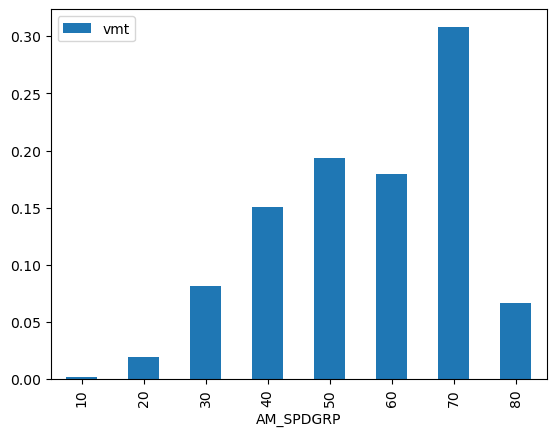

In [32]:
(dy_net[dy_net['LINKCLASS'] < 99].groupby('AM_SPDGRP').agg(vmt = ('VMT_AM', sum)) / dy_net[dy_net['LINKCLASS'] < 99]['VMT_AM'].sum()).plot.bar()

<Axes: xlabel='AM_VCGRP'>

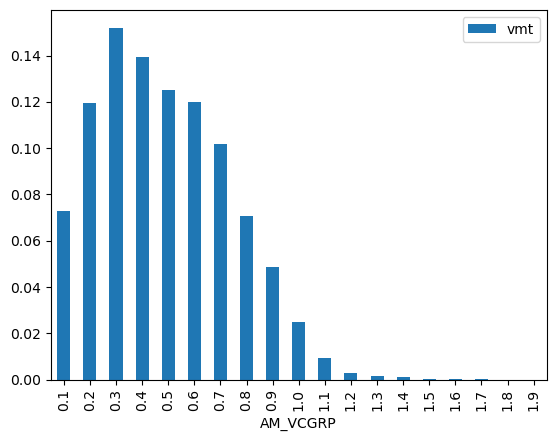

In [33]:
(dy_net[(dy_net['LINKCLASS'] < 99) & (dy_net[f'CAP_AM'] > 0) & (dy_net[f'CAP_AM'] < 99999)].groupby('AM_VCGRP').agg(vmt = ('VMT_AM', sum)) / dy_net[dy_net['LINKCLASS'] < 99]['VMT_AM'].sum()).plot.bar()

<Axes: xlabel='MD_SPDGRP'>

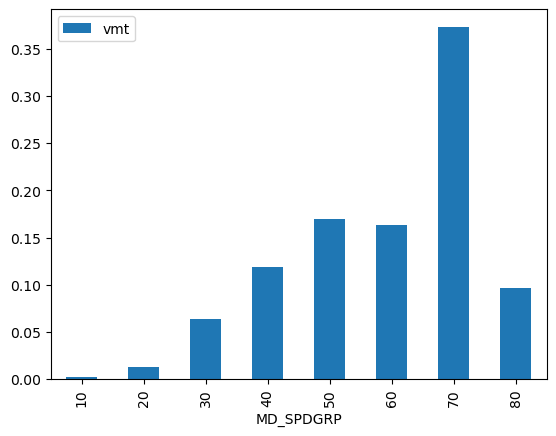

In [34]:
(dy_net[dy_net['LINKCLASS'] < 99].groupby('MD_SPDGRP').agg(vmt = ('VMT_MD', sum)) / dy_net[dy_net['LINKCLASS'] < 99]['VMT_MD'].sum()).plot.bar()

<Axes: xlabel='MD_VCGRP'>

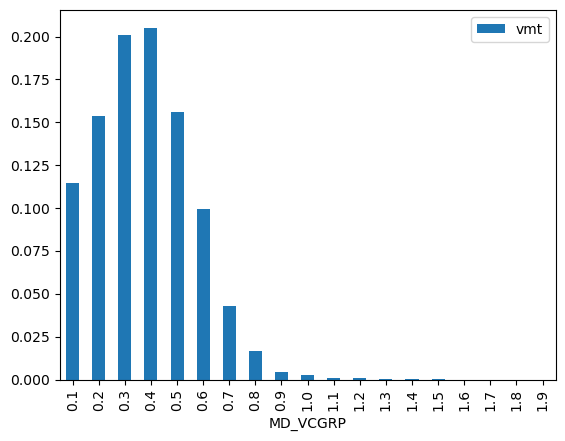

In [35]:
(dy_net[(dy_net['LINKCLASS'] < 99) & (dy_net[f'CAP_MD'] > 0) & (dy_net[f'CAP_MD'] < 99999)].groupby('MD_VCGRP').agg(vmt = ('VMT_MD', sum)) / dy_net[dy_net['LINKCLASS'] < 99]['VMT_MD'].sum()).plot.bar()

<Axes: xlabel='PM_SPDGRP'>

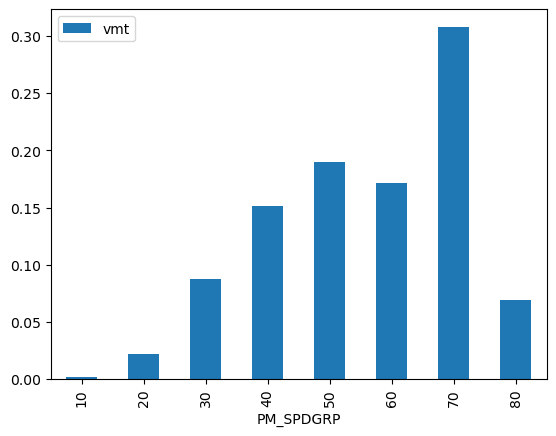

In [36]:
(dy_net[dy_net['LINKCLASS'] < 99].groupby('PM_SPDGRP').agg(vmt = ('VMT_PM', sum)) / dy_net[dy_net['LINKCLASS'] < 99]['VMT_PM'].sum()).plot.bar()

<Axes: xlabel='PM_VCGRP'>

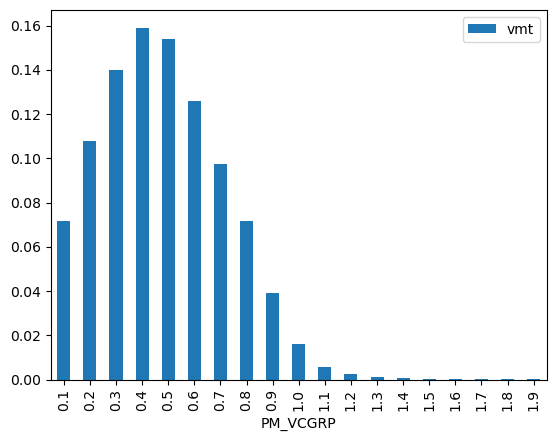

In [37]:
(dy_net[(dy_net['LINKCLASS'] < 99) & (dy_net[f'CAP_PM'] > 0) & (dy_net[f'CAP_PM'] < 99999)].groupby('PM_VCGRP').agg(vmt = ('VMT_PM', sum)) / dy_net[dy_net['LINKCLASS'] < 99]['VMT_PM'].sum()).plot.bar()

<Axes: xlabel='NT_SPDGRP'>

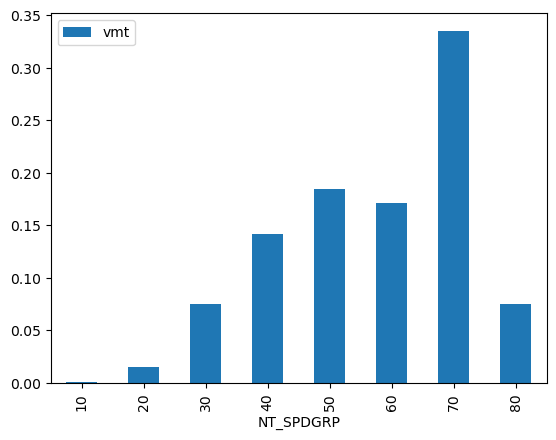

In [38]:
(dy_net[dy_net['LINKCLASS'] < 99].groupby('NT_SPDGRP').agg(vmt = ('VMT_NT', sum)) / dy_net[dy_net['LINKCLASS'] < 99]['VMT_NT'].sum()).plot.bar()

<Axes: xlabel='NT_VCGRP'>

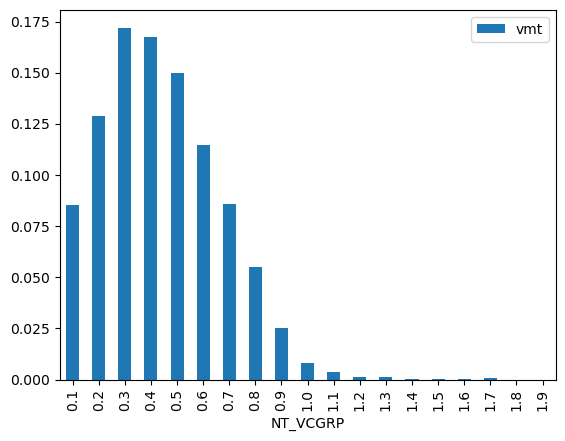

In [39]:
(dy_net[(dy_net['LINKCLASS'] < 99) & (dy_net[f'CAP_NT'] > 0) & (dy_net[f'CAP_NT'] < 99999)].groupby('NT_VCGRP').agg(vmt = ('VMT_NT', sum)) / dy_net[dy_net['LINKCLASS'] < 99]['VMT_NT'].sum()).plot.bar()

# HPMS Comparison

In [40]:
vmt_county['Obs_VMT'].sum()

96226065.131

In [41]:
link_join['Model_VMT'] = link_join['Model_mainline'] * link_join['DISTANCE']
model_co_vmt = link_join.groupby('CO_NAME').agg(Model_VMT = ('Model_VMT', 'sum')).join(vmt_county)
model_co_vmt

model_co_vmt['Difference'] = model_co_vmt['Model_VMT'] - model_co_vmt['Obs_VMT']
model_co_vmt['Pct Difference'] = model_co_vmt['Difference'] / model_co_vmt['Obs_VMT']

model_co_vmt.style.format({'Model_VMT': '{:,.0f}', 'Obs_VMT': '{:,.0f}', 'Difference': '{:,.0f}', 'Pct Difference': '{:.2%}'})

,Model_VMT,Obs_VMT,Difference,Pct Difference
CO_NAME,,,,
Anoka,"7,439,105","8,399,116","-960,011",-11.43%
Carver,"2,551,968","2,410,559","141,409",5.87%
Chisago,"1,558,101","2,225,375","-667,274",-29.98%
Dakota,"10,127,207","10,830,531","-703,324",-6.49%
Goodhue,"1,837,405","1,899,308","-61,902",-3.26%
Hennepin,"31,364,302","29,585,245","1,779,057",6.01%
Isanti,"995,952","1,170,623","-174,671",-14.92%
Le Sueur,"761,257","786,403","-25,146",-3.20%
McLeod,"773,562","989,717","-216,154",-21.84%


In [42]:
net_summary = pd.DataFrame([model_co_vmt[['Model_VMT', 'Obs_VMT']].sum()])
net_summary['Difference'] = net_summary['Model_VMT'] - net_summary['Obs_VMT']
net_summary['Pct Difference'] = net_summary['Difference'] / net_summary['Obs_VMT']

net_summary.style.format({'Model_VMT': '{:,.0f}', 'Obs_VMT': '{:,.0f}', 'Difference': '{:,.0f}', 'Pct Difference': '{:.2%}'})

,Model_VMT,Obs_VMT,Difference,Pct Difference
0,"94,511,541","96,226,065","-1,714,524",-1.78%
